In [11]:
### IMPORTS ###
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

/Users/justinlacoste/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
######################################################
###### TASK 1: DATA ACQUISITION AND EXPLORATION ######
######################################################

In [12]:
### LOAD AND PREPARE DATA ###

#Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


#Vectorize images
x_train = np.array([np.float64(x.flatten()) for x in x_train])
x_test = np.array([np.float64(x.flatten()) for x in x_test])


#Normalize images
x_train -= np.mean(x_train, axis = 0)
x_train /= np.std(x_train, axis = 0)
x_test -= np.mean(np.float64(x_test), axis = 0)
x_test /= np.std(x_test, axis = 0)

#One hot encoding of labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)


#Insert '1' for bias
x_train = np.insert(x_train, 0, [1] * len(x_train), axis=1)
x_test = np.insert(x_test, 0, [1] * len(x_test), axis=1)


print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

170498071/170498071 [==============================] - 8s 0us/step
Train: X=(50000, 3073), y=(50000, 10)
Test: X=(10000, 3073), y=(10000, 10)


In [188]:
#Explore data
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
l_train = [label_names[np.argmax(y)] for y in y_train]
c_train = [l.count(x) for x in l]
d_train = dict(zip(l,c))

l_test = [label_names[np.argmax(y)] for y in y_test]
c_test = [l.count(x) for x in l]
d_test = dict(zip(l,c))

print("training set: ", d_train)
print("test set: ", d_test)

training set:  {'airplane': 1000, 'frog': 1000, 'dog': 1000, 'automobile': 1000, 'truck': 1000, 'deer': 1000, 'ship': 1000, 'cat': 1000, 'bird': 1000, 'horse': 1000}
test set:  {'airplane': 1000, 'frog': 1000, 'dog': 1000, 'automobile': 1000, 'truck': 1000, 'deer': 1000, 'ship': 1000, 'cat': 1000, 'bird': 1000, 'horse': 1000}


In [195]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MultiLayerPerceptron:

  def __init__(self, activation_function, num_hidden_layers, hidden_layers_width, l1_lambda=None, l2_lambda=None):
    self.activation_function = activation_function
    self.num_hidden_layers = num_hidden_layers
    self.hidden_layers_width = hidden_layers_width
    self.l1_lambda = l1_lambda
    self.l2_lambda = l2_lambda
    self.loss_per_epoch = []
    self.total_number_of_epochs = 0
    self.train_accuracies = []
    self.test_accuracies = []


    #Initialize weights with given number of hidden layers (0, 1 or 2)
    if num_hidden_layers == 0:
      self.w1 = np.random.rand(10, 3073)/1000

    elif num_hidden_layers == 1:
      if len(hidden_layers_width) != 1:
        raise Exception("Invalid input: len(hidden_layers_width) != num_hidden_layers")
      self.w1 = np.random.rand(hidden_layers_width[0], 3073)/100
      self.w2 = np.random.rand(10, hidden_layers_width[0])/100

    elif num_hidden_layers == 2:
      if len(hidden_layers_width) != 2:
        raise Exception("Invalid input: len(hidden_layers_width) != num_hidden_layers")
      self.w1 = np.random.rand(hidden_layers_width[0], 3073)/100
      self.w2 = np.random.rand(hidden_layers_width[1], hidden_layers_width[0])/100
      self.w3 = np.random.rand(10, hidden_layers_width[1])/100
    else:
      raise Exception("Unsupported number of hidden layers")


  def fit(self, x, y, learning_rate, epsilon, max_iters, batch_size, x_test=[], y_test=[]):

    num_of_batches = int(len(x)/batch_size)
    x_batches = np.array_split(x, num_of_batches)
    y_batches = np.array_split(y, num_of_batches)

    #Gradient descent
    norms = np.array([np.inf])
    t = 0
    print("Epochs: ")
   

    #RELU WITH 0 HIDDEN LAYERS
    if self.activation_function == self.relu and self.num_hidden_layers == 0:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad #* (1/num_of_batches)
          t += 1
          norms = np.array([np.linalg.norm(g) for g in grad])
          print(t, end=' ')
        
          self.one_epoch_ran(x, x_test, y, y_test)
    
      print("")
      print(f"{t} iterations performed")

    #RELU WITH 1 HIDDEN LAYERS
    elif self.activation_function == self.relu and self.num_hidden_layers == 1:
      while t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2 = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 #* (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 #* (1/num_of_batches)
            
          self.one_epoch_ran(x, x_test, y, y_test)
            
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")

        
    #RELU WITH 2 HIDDEN LAYERS
    elif self.activation_function == self.relu and self.num_hidden_layers == 2:
      while t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2, grad_w3 = self.relu_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 #* (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 #* (1/num_of_batches)
            self.w3 -= learning_rate * grad_w3 #* (1/num_of_batches)
            
          self.one_epoch_ran(x, x_test, y, y_test)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")


    
    #TAN_H WITH 0 HIDDEN LAYERS
    elif self.activation_function == self.tanh and self.num_hidden_layers == 0:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad * (1/num_of_batches)
          t += 1
          norms = np.array([np.linalg.norm(g) for g in grad])
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")


    #TAN_H WITH 1 HIDDEN LAYERS
    elif self.activation_function == self.tanh and self.num_hidden_layers == 1:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2 = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 * (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 * (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")


    #TAN_H WITH 2 HIDDEN LAYERS
    elif self.activation_function == self.tanh and self.num_hidden_layers == 2:
      while np.any(norms > epsilon) and t < max_iters:
          for batch in range(num_of_batches):
            grad_w1, grad_w2, grad_w3 = self.tanh_gradient(x_batches[batch], y_batches[batch])
            self.w1 -= learning_rate * grad_w1 * (1/num_of_batches)
            self.w2 -= learning_rate * grad_w2 * (1/num_of_batches)
            self.w3 -= learning_rate * grad_w3 * (1/num_of_batches)
          t += 1
          print(t, end=' ')
      print("")
      print(f"{t} iterations performed")


    #Displaying graph at the end
    plt.plot(range(len(self.loss_per_epoch)), self.loss_per_epoch)
    plt.title("Training Loss per Step")
    plt.show()
    plt.plot(range(len(self.train_accuracies)), self.train_accuracies, label="train")
    plt.plot(range(len(self.test_accuracies)), self.test_accuracies, label="test")
    plt.legend(loc="upper right")
    plt.title("Train/Test Accuracy per Epoch")
    plt.show()
    print("Training Accuracy: ", self.train_accuracies[-1]*100, "%")
    print("Test Accuracy: ",self.test_accuracies[-1]*100, "%")
    


  def relu_gradient(self, x, y):

    y_hat = self.predict(x)
    self.loss_per_epoch.append(MultiLayerPerceptron.total_loss(y, y_hat))
    N, D = x.shape

    if self.num_hidden_layers == 0:
      dy = y_hat - y
      dw1 = np.matmul(np.transpose(dy), x)
      return dw1

    elif self.num_hidden_layers == 1:
      dy = y_hat - y
      dw = (np.dot(self.z1_for_gradient, dy) / N).T
      dz = np.dot(dy, self.w2)
      dv = (np.dot(x.T, dz * (self.q1_for_gradient > 0).astype(int).T) / N).T
      return dv, dw
    elif self.num_hidden_layers == 2:
      dy = y_hat - y
      dw3 = (np.dot(self.z2_for_gradient, dy) / N).T
      dz2 = np.dot(dy, self.w3)
      dw2 = ((np.dot(self.z1_for_gradient, dz2 * (self.q2_for_gradient > 0).astype(int).T)) / N).T
      dz1 = np.dot(dz2 * (self.q2_for_gradient > 0).astype(int).T, self.w2)
      dw1 = ((np.dot(x.T, dz1 * (self.q1_for_gradient > 0).astype(int).T)) / N).T
      return dw1, dw2, dw3



  def tanh_gradient(self, x, y):
    y_hat = self.predict(x)
    self.loss_per_epoch.append(MultiLayerPerceptron.total_loss(y, y_hat))
    N, D = x.shape

    if self.num_hidden_layers == 0:
      dy = y_hat - y
      dw1 = np.matmul(np.transpose(dy), x)
      return dw1

    elif self.num_hidden_layers == 1:
      dy = y_hat - y
      dw = (np.dot(self.z1_for_gradient, dy) / N).T
      dz = np.dot(dy, self.w2)
      dv = (np.dot(x.T, dz * (1 - (self.z1_for_gradient.T)**2)) / N).T
      return dv, dw

    elif self.num_hidden_layers == 2:
      dy = y_hat - y
      dw3 = (np.dot(self.z2_for_gradient, dy) / N).T
      dz2 = np.dot(dy, self.w3)
      dw2 = (np.dot(self.z1_for_gradient, dz2 * (1 - (self.z2_for_gradient.T)**2)) / N).T
      dz1 = np.dot(dz2 * (1 - (self.z2_for_gradient.T)**2), self.w2)
      dw1 = ((np.dot(x.T, dz1 * (1 - (self.z1_for_gradient.T)**2))) / N).T
      return dw1, dw2, dw3


  def predict(self, x):

    if self.num_hidden_layers == 0:
      return self.softmax(np.transpose(np.dot(self.w1, np.transpose(x))))

    elif self.num_hidden_layers == 1:
      q1 = np.dot(self.w1, np.transpose(x))
      z1 = self.activation_function(q1)
      self.q1_for_gradient = q1
      self.z1_for_gradient = z1
      return self.softmax(np.transpose(np.dot(self.w2, z1)))
    else:
      q1 = np.dot(self.w1, np.transpose(x))
      z1 = self.activation_function(q1)
      self.q1_for_gradient = q1
      self.z1_for_gradient = z1
      q2 = np.matmul(self.w2, z1)
      z2 = self.activation_function(q2)
      self.q2_for_gradient = q2
      self.z2_for_gradient = z2
      return self.softmax(np.transpose(np.matmul(self.w3, z2)))

  
  @staticmethod
  def relu(x):
    return (x + np.abs(x))/2

  @staticmethod
  def leaky_relu(x):
    y1 = ((x > 0) * x)                                                 
    y2 = ((x <= 0) * x * 0.01)                                         
    return y1 + y2  

  @staticmethod
  def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

  @staticmethod
  def softmax(x):
    R, C = x.shape
    for i in range(R):
      if max(x[i]) > 709:
        denominator = sum(x[i])
        for j in range(C):
          x[i][j] = np.exp(x[i][j])/denominator
        highest_idx = np.argmax(x[i])
        x[i][highest_idx] = 1
        continue


      denominator = sum([np.exp(j) for j in x[i]])
      denominator = denominator if denominator > 0 else 1
      for j in range(C):
        x[i][j] = np.exp(x[i][j])/denominator
    return x

  @staticmethod
  def accuracy(y, y_hat):

    accurate_classifications = 0

    for i, y in enumerate(y):
      category = np.argmax(y)
      predicted_category = np.argmax(y_hat[i])

      if category == predicted_category:
        accurate_classifications += 1

    return accurate_classifications/len(y_hat)

  @staticmethod
  def total_loss(y, y_hat):

    loss = 0

    for i, y in enumerate(y):
      category = np.argmax(y)
      predicted_value = y_hat[i][category]
      loss += (-1 * np.log(predicted_value))

    return loss

  def one_epoch_ran(self, x_train, x_test, y_train, y_test):
    self.total_number_of_epochs += 1
    yh_train = self.predict(x_train)
    yh_test = self.predict(x_test)
    self.compute_accuracies(y_train, yh_train, y_test, yh_test)
    self.model_checkpoint()

  
  def save_weights_loss_accuracies(self, filename):
    if self.num_hidden_layers == 0:
      np.save(filename, np.array([self.w1, self.loss_per_epoch, self.train_accuracies, self.test_accuracies],dtype=object))
    elif self.num_hidden_layers == 1:
      np.save(filename, np.array([self.w1, self.w2, self.loss_per_epoch, self.train_accuracies, self.test_accuracies],dtype=object))
    elif self.num_hidden_layers == 2:
      np.save(filename, np.array([self.w1, self.w2, self.w3, self.loss_per_epoch, self.train_accuracies, self.test_accuracies],dtype=object))
    return
    
  def compute_accuracies(self, y_train, yh_train, y_test, yh_test):
    train_accuracy = MultiLayerPerceptron.accuracy(y_train, yh_train)
    test_accuracy = MultiLayerPerceptron.accuracy(y_test, yh_test)
    self.train_accuracies.append(train_accuracy)
    self.test_accuracies.append(test_accuracy)
    return
    
  def model_checkpoint(self):
    if self.total_number_of_epochs > 0 and self.total_number_of_epochs % 50 == 0:
        train_accuracy = round(self.train_accuracies[-1]*100)
        test_accuracy = round(self.test_accuracies[-1]*100)
        filename = f"{self.num_hidden_layers}_layers_{self.activation_function.__name__}_{train_accuracy}train_{test_accuracy}test.npy"
        self.save_weights_loss_accuracies(filename)
        
  def load_model(self, model_checkpoint_name):
    if self.num_hidden_layers == 0:
      self.w1, self.loss_per_epoch, self.train_accuracies, self.test_accuracies = np.load(model_checkpoint_name, allow_pickle=True)
    elif self.num_hidden_layers == 1:
      self.w1, self.w2, self.loss_per_epoch, self.train_accuracies, self.test_accuracies = np.load(model_checkpoint_name, allow_pickle=True)
    elif self.num_hidden_layers == 2:
      self.w1, self.w2, self.w3, self.loss_per_epoch, self.train_accuracies, self.test_accuracies = np.load(model_checkpoint_name, allow_pickle=True)


In [27]:
### SHUFFLE ###
shuffle = list(zip(x_train, y_train))
random.shuffle(shuffle)
x_train, y_train = zip(*shuffle)

shuffle = list(zip(x_test, y_test))
random.shuffle(shuffle)
x_test, y_test = zip(*shuffle)

In [ ]:

#####################
###### TASK 1 #######
#####################


Epochs: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
20 iterations performed


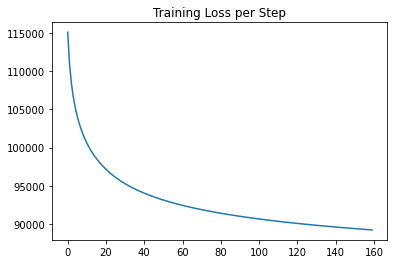

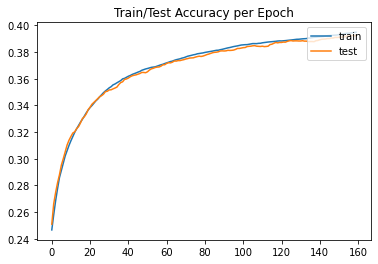

Training Accuracy:  39.486 %
Test Accuracy:  39.24 %


In [137]:
### 0 HIDDEN-LAYER TRAINING ###
mlp_0 = MultiLayerPerceptron(MultiLayerPerceptron.relu, 0, [])
mlp_0.fit(x_train, y_train, learning_rate=0.0000001, epsilon=0.0000001, max_iters=20, batch_size=50000, x_test=x_test, y_test=y_test)

In [ ]:
### 1 HIDDEN-LAYER TRAINING ###
#mlp_1 = MultiLayerPerceptron(MultiLayerPerceptron.relu, 1, [256])
mlp_1.fit(x_train, y_train, learning_rate=0.02, epsilon=0.0000001, max_iters=100, batch_size=10000, x_test=x_test, y_test=y_test)

In [193]:
mlp_2 = MultiLayerPerceptron(MultiLayerPerceptron.relu, 2, [256, 256])
mlp_2.load_model('2_layers_relu_38train_38test.npy')

Epochs: 
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 
20 iterations performed


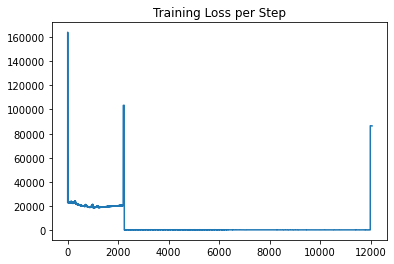

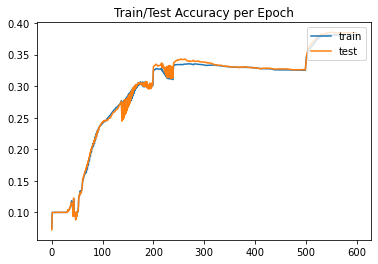

Training Accuracy:  38.124 %
Test Accuracy:  38.46 %


In [194]:
### 2 HIDDEN-LAYER TRAINING ###
# mlp_2 = MultiLayerPerceptron(MultiLayerPerceptron.relu, 2, [256, 256])
mlp_2.fit(x_train, y_train, learning_rate=0.0001, epsilon=0.00000007, max_iters=20, batch_size=50000, x_test=x_test, y_test=y_test)

In [ ]:

#####################
###### TASK 2 #######
#####################


In [ ]:
mlp_2_tanh = MultiLayerPerceptron(MultiLayerPerceptron.tanh, 2, [256, 256])
mlp_2_tanh.load_model('2_layers_relu_38train_38test.npy')